# Simple BSE demo/walkthrough
Dave Cliff, University of Bristol, October 2022




## BSE System Architecture

The figure below shows a schematic illustration of the overall architecture of the *Bristol Stock Exchange* (BSE), a simulation of a contemporary fully electronic financial exchange with automated traders.

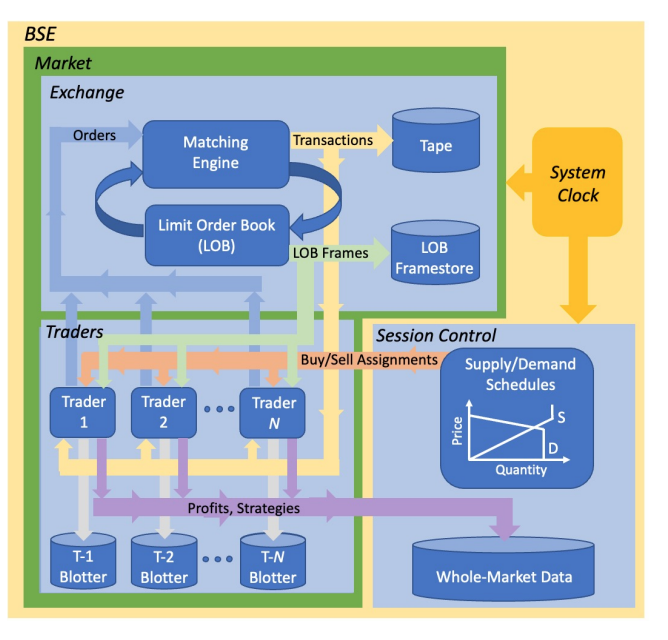

BSE simulates a *market*, composed of an *exchange* and some number *N* of *traders* which each interact with the exchange. Any one simulation of a market session proceeds according to BSE's *system clock*, which provides a unified time signal to all elements of the simulation.

Separate from the simulation of the market is BSE's *session control* logic, which determines the (potentially time-dependent) market's *supply and demand schedule* (SDS): this is used to issue *assignments* to the traders, i.e. allocations of cash and limit-prices to buyers, and allocations of stock and limit-prices to sellers -- this is the simulation's correlate of real-world market *customer orders* coming from customers to sales-traders who are responsible for working each customer order. The session-control logic is also responsible for recording whole-market data, such as the profits and strategy-values of each trader in the market, as were visualised in the graphs and plots earlier in this paper.

The exchange receives orders from the traders: *bids* from buyers; *asks* from sellers. When each order arrives at the exchange, it is processed by the *matching engine*, attempting to find one or more matching bids for a newly-arrived ask, or one or more matching asks for a newly-arrived bid. It does this by comparing the new order to those earlier orders, as yet unfulfilled, that are "resting" at the exchange and which are summarised in aggregated and anonymized form on the exchange's *limit order book* (LOB). If a new order can be matched with one or more existing orders on the LOB then the matching orders are removed from the LOB, and the new order plus its counterparty orders from the LOB are recorded as fulfilled, resulting in a transaction taking place. When a transaction occurs, its details are written to the exchange's public record of transactions which is commonly referred to as the exchange's *tape* -- the tape records transactions and also other notable market events, such as cancellations of existing orders. When a transaction occurs, the exchange also notifies the traders concerned, adjusting their cash balances appropriately. The BSE exchange also can be configured to write the state of the LOB at any one instance (referred to as a *LOB frame*) to an external record, the *LOB framestore*, for subsequent analysis.

Each of the *N* traders in the market receives occasional fresh assignments from the session control, all have the same view of the LOB data published by the exchange, and when a trader is involved in a transaction it receives notification of the relevant details from the exchange's matching engine. Each trader is able to send orders to the exchange, and to send cancellations of existing orders, and each maintains its own local private record of assignments received, orders sent to the exchange, and transaction details received from the exchange: this is conventionally referred to as the trader's *blotter*.


## Using BSE: a first walk-through

Let's start by using BSE to replicate the experiment that Vernon Smith showed results from in Chart 1 of his landmark 1962 JPE paper *"An Experimental Study of Competitive Market Behavior"* -- this was Smith's first reported CDA experiment.

For a PDF version of Smith's 1962 paper, see here: https://www.journals.uchicago.edu/doi/abs/10.1086/258609

First of all let's import what we'll need.

In [14]:
# un-comment these lines if you need to install the packages
# !{sys.executable} pip3 install numpy
# !{sys.executable} pip3 install matplotlib

import matplotlib.pyplot as plt
import numpy as np
import csv
import random

from BSE import market_session

Let's say all our experiments are to last for 10 simulated minutes...

In [15]:
start_time = 0
end_time = 60 * 10

The supply and demand curves in Smith's Chart 1 are symmetric: they each involve 11 traders, each given an assignment to trade (buy or sell) a single unit.

On both curves the minimum price was 80 and the max was 320,
and the step-size between successive prices was always 20

In [16]:
chart1_range=(80, 320)

supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [chart1_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [chart1_range], 'stepmode': 'fixed'}]

Smith used periodic updating -- at the start of each "day" all traders are issued with fresh assignments.

Let's do that once every 60 seconds

In [17]:
order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

And finally let's use 11 ZIP traders on each side, buyers and sellers, because ZIP gives reasonably human-like market dynamics.

In [18]:
sellers_spec = [('ZIP', 11)]
buyers_spec = sellers_spec
prop_traders_spec = []
traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec, 'proptraders': prop_traders_spec}

When we run a BSE market session we can alter how verbose it is, how much it tells us about what is going on, but this can generate a *lot* of text, so let's switch that off for the time being.

In [19]:
verbose = False

Finally BSE (which was originally created before the days of Jupyter notebooks) writes output data-files
in csv format for later anaylsis, so we need to give it a session-identifier string which will be used at the start of all this session's data-files, and what data to dump into files.


In [20]:

trial_id = 'smith_chart_1'
dump_flags = {'dump_blotters': True, 'dump_lobs': True, 'dump_strats': True,
              'dump_avgbals': True, 'dump_tape': True}

And now we're ready to go... we'll run a market session, which dumps data to a file, and then we'll immediately read the file back and plot a graph of the transaction-price time-series.


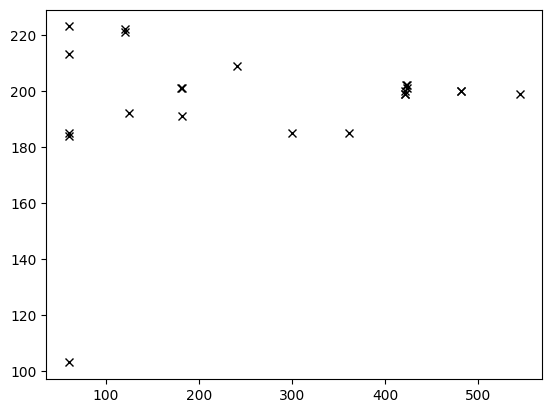

In [21]:
random.seed(100) # changing the seed value will give us different seqences of random numbers

market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)

prices_fname = trial_id + '_tape.csv'
x = np.empty(0)
y = np.empty(0)
with open(prices_fname, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        time = float(row[1])
        price = float(row[2])
        x = np.append(x,time)
        y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

But that's just one run from a stochastic system: if we run it again with a different random seed we'll get a different sequence of events.

Note that while ZIP is pretty good at doing what it does, there are a couple of known issues when a market is populated entirely by ZIP traders (i.e., when it is a homogeneous population of ZIPs): (a) sometimes a homogenous ZIP market will fail to equilibrate at all, or maybe it will converge to a steady-state range of transaction prices that is clearly off-equilibrium; or (b) sometimes a homogeneous ZIP market will grind to a halt, with a total cessation of trading.

The behavior of each ZIP trader is determined by eight numeric parameters such as its
learning rate, its momentum parameter, and the two constants used for relative and absolute perturbation of the target price -- these parameters can be fine-tuned to particular market scenarios, and if the parameters are not tuned to the market situation, sometimes problem (a) occurs.

Also ZIP, as implemented here, was originally intended for operating in simulation models of open-outcry trading pits, where there is a lot of (noisy) information to act upon. In a Limit Order Book (LOB) trading scenario, ZIP does not always do so well and sometimes a homogeneous population of ZIPs "locks up", causing problem (b), because every ZIP in the market is waiting for some other ZIP to issue a quote that changes the LOB, and because they are all waiting, nobody does anything. This problem disappears once there are one or more other traders present, even if they're just noise traders like Gode & Sunder's ZI-U or ZI-C, because the other traders put enough life into the LOB to prevent the ZIPs from locking up.



Analysis of individual runs is important, but it's also important to characterise the general behavior of the system -- for example, we could do 10 or 50 or 100 (or more) independent and identically distributed (iid) runs, and compute summary statistics. In the original ZIP paper (HP Labs Technical Report, 1997) multiple transaction-price time series were summarised by showing the mean price plus and minus one standard deviation. That's a very straightforward way of doing things.

Let's take the code in the previous cell and wrap a loop around it, so that instead of doing a single session, it does n_sessions.

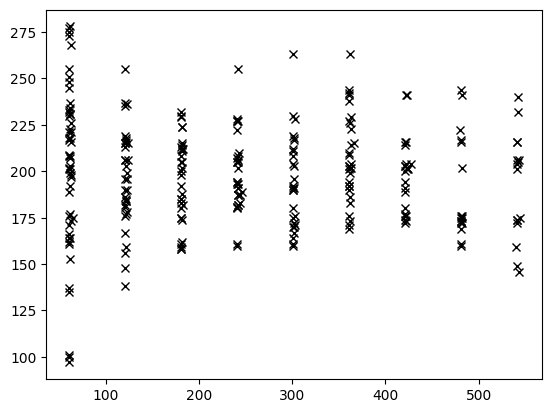

In [22]:
n_sessions = 10

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)

    prices_fname = trial_id + '_tape.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

As you can see, ZIP is not perfect (ZIP was originally written to operate in a market
that is a model of an open-outcry trading pit, rather than a LOB), but the results we're getting here from ZIP in BSE are illustrative of machine trading on an automated exchange: no-one is saying ZIP is optimal!

To make things a bit more realistic, let's change the re-supply of buyer and seller assignments from periodic to stochastic, feeding them into the market via a Poisson process, and make the schedule re-supply be on a 10-second cycle...

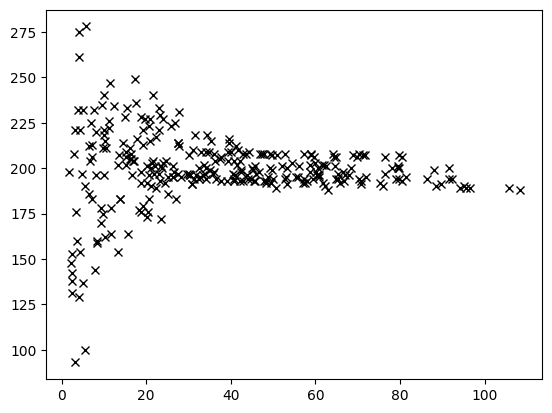

In [23]:
order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 10

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)

    prices_fname = trial_id + '_tape.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

And let's increase the number of traders from 11 on each side to
something bigger, say 40...

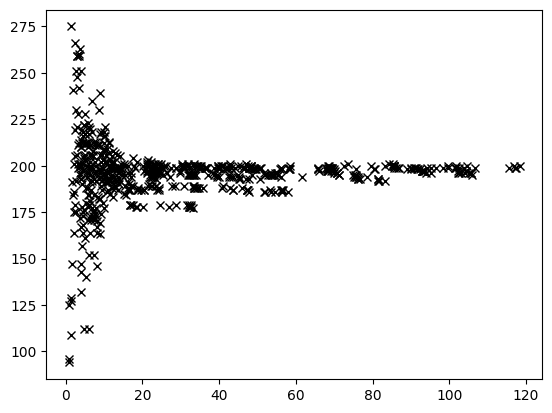

In [24]:
sellers_spec = [('ZIP', 40)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 10

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)

    prices_fname = trial_id + '_tape.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

And let's introduce some variety into the population of traders, have a mix of different strategies.

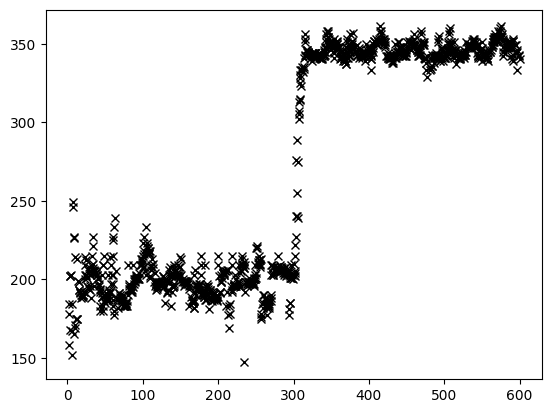

In [27]:
sellers_spec = [('ZIP', 10), ('ZIC', 10), ('SHVR', 10), ('GVWY', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 1

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)

    prices_fname = trial_id + '_tape.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

Everything we've done so far has had a single static supply and demand schedule. But in real markets, the supply and demand schedules are constantly varying -- often by only small amounts, but occasionally there might be large "shock" changes.

Let's introduce a shock, part-way through the session.

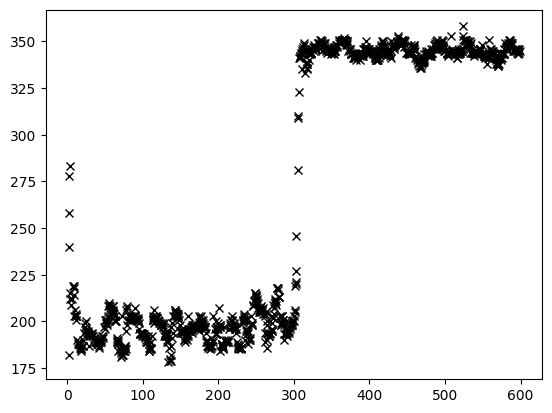

In [28]:
shocked_range = (300, 400)
shock_time = int(end_time / 2)

supply_schedule = [ {'from':0, 'to':shock_time, 'ranges':[chart1_range], 'stepmode':'fixed'},
              {'from':shock_time, 'to':end_time, 'ranges':[shocked_range], 'stepmode':'fixed'},
            ]
demand_schedule = supply_schedule

sellers_spec = [('ZIP', 10), ('ZIC', 10), ('SHVR', 10), ('GVWY', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 1

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)

    prices_fname = trial_id + '_tape.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

That's it for now: this notebook has shown you how to set up BSE to run market sessions like Vernon Smith's first experiment in his landmark 1962 JPE paper, and then has shown you how to alter and extend the setup to take it closer to real-world market scenarios: a heterogeneous mix of trader-types; supply/demand assignments arriving randomly; and the supply and demand schedules altering during the session.

## Further Reading

Here are links to some recent research papers that use BSE...

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4153519 

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4154426 

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4070885

https://arxiv.org/abs/2012.08840

https://arxiv.org/abs/2012.00821

https://arxiv.org/abs/2011.14346